Lo scopo di questo esperimento è verificare se tramite una semplice rete convoluzionale ed un toy dataset i qui dettagli verranno definiti in seguito è possibile ottenere informazioni sulla posizione di una classe.

La classe in questione è così definita:

- class **A-left**: tag *0*
- class **A-right**: tag *1*
- class **B-left**: tag *2*
- class **B-right**: tag *3*

In [1]:
from Experiment2 import *

from ToyDataset import ToyDataset

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import warnings
import skdim

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

torch.manual_seed(43)

# Dataset definition

tag: 0, class: ['A-left', 'sx high-low']
tag: 1, class: ['A-right', 'dx high-low']
tag: 2, class: ['B-left', 'sx low-high']
tag: 3, class: ['B-right', 'dx low-high']


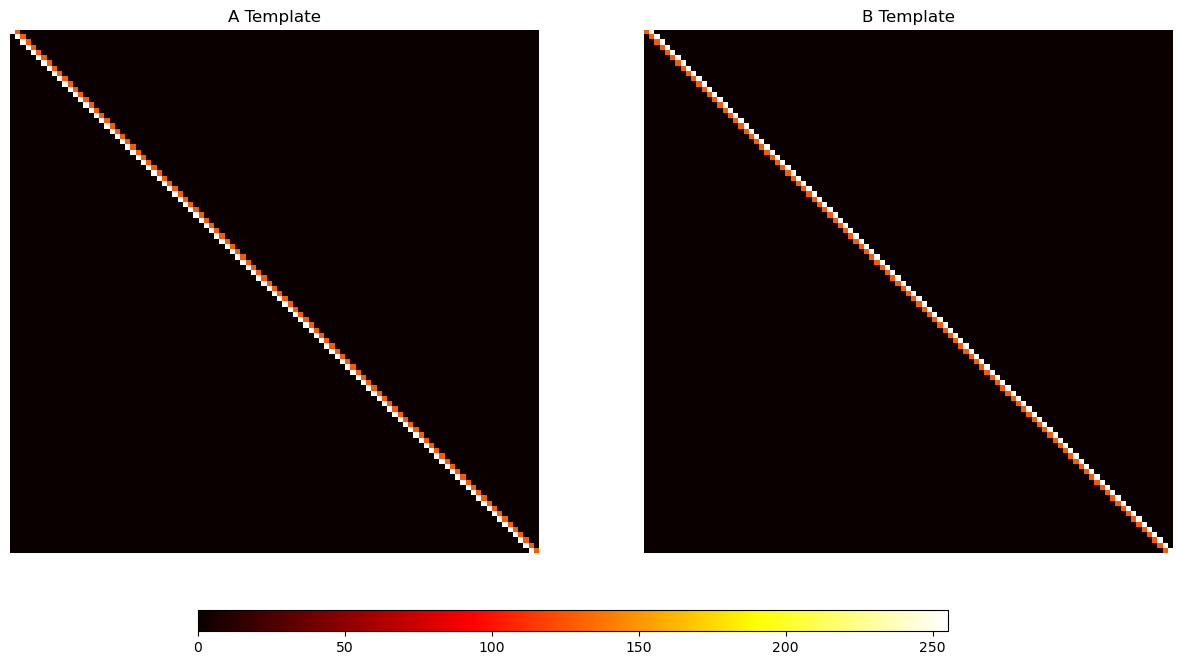

tag: 0, class: ['A', 'high-low']
tag: 1, class: ['B', 'low-high']


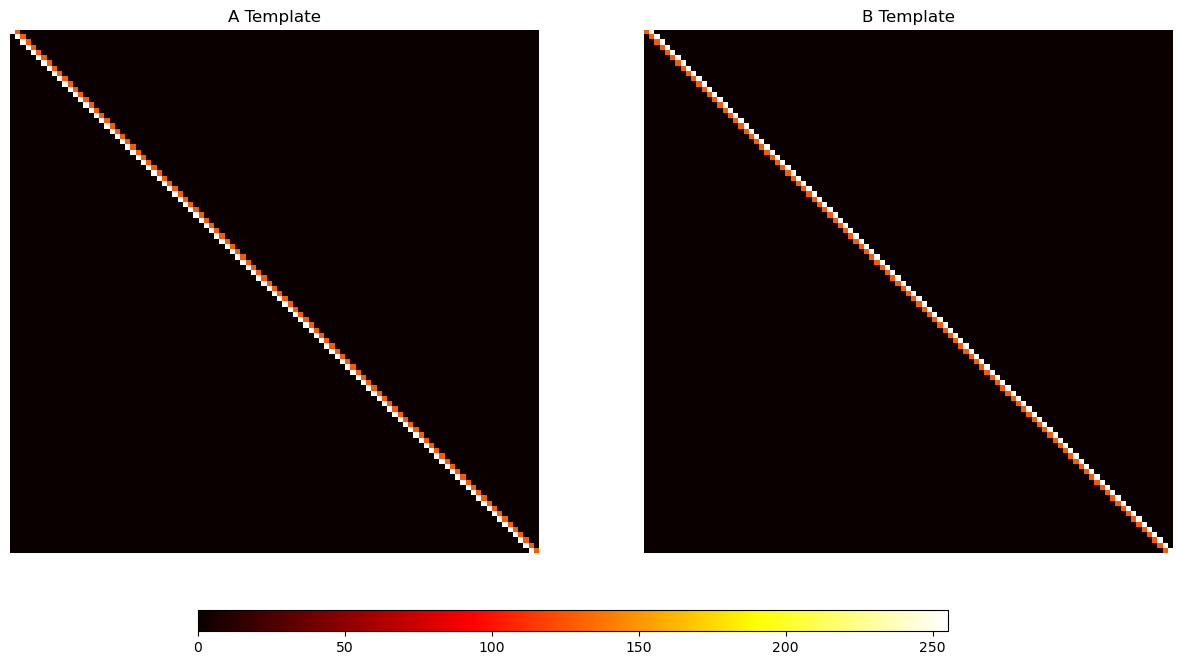

In [2]:
dset = ToyDataset(noise_level=10, class_values=(127, 255), input_size=101, inter_class_size=10, binary=False)
binary_dset = ToyDataset(noise_level=10, class_values=(127, 255), input_size=101, inter_class_size=10, binary=True)

trainset, testset = random_split(dset, [0.8, 0.2])
btrainset, btestset = random_split(binary_dset, [0.8, 0.2])

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

btrainloader = DataLoader(btrainset, batch_size=BATCH_SIZE, shuffle=True)
btestloader = DataLoader(btestset, batch_size=BATCH_SIZE, shuffle=False)

dset.show_label_map()
dset.show_templates()
binary_dset.show_label_map()
binary_dset.show_templates()

# Phase 1

100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


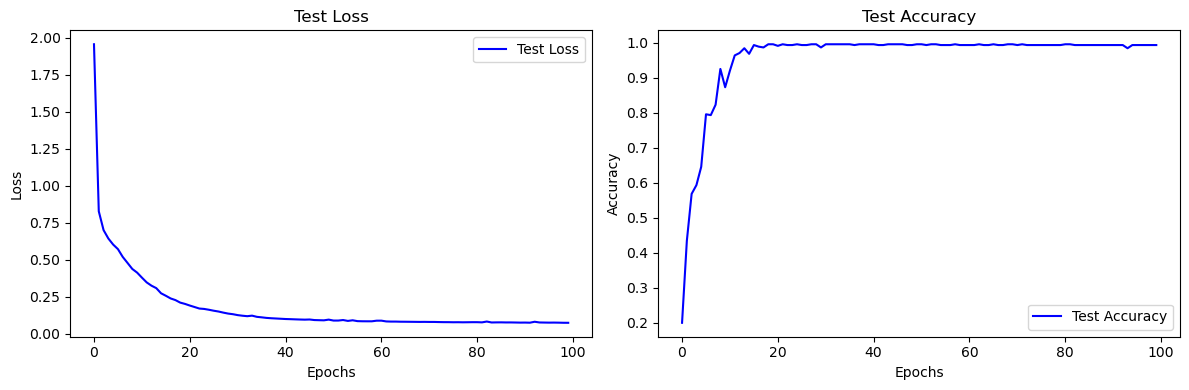

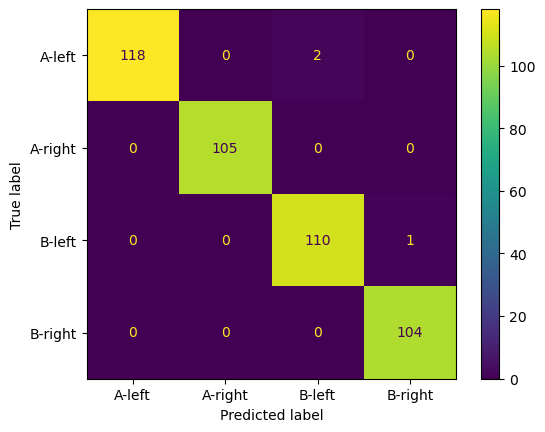

In [3]:
model1 = SimpleArchitecture(filter_size=2, input_size=dset.input_size, output_size=len(dset.label_map.keys()))

phase1 = Experiment2(trainloader=trainloader, testloader=testloader, label_map=dset.label_map, model=model1, lr=1e-2, epochs=100)

phase1.run()

# Phase 2

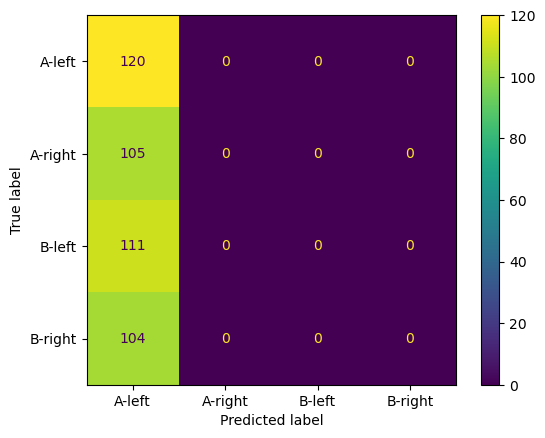

In [4]:
model2 = SimpleConvWithPooling(filter_size=2, input_size=dset.input_size, dataloader_for_ranges=trainloader)

model2.conv[0] = model1.conv[0]
model2.conv[1] = model1.conv[1]

model2.conv.apply(lambda m: set_requires_grad(m, False))

phase2 = Experiment2(trainloader=trainloader, testloader=testloader, label_map=dset.label_map, model=model2, lr=1e-2, epochs=100)

phase2.run(re_train=False)

From this *simpleArcWithPooling.ranges* datum alone we can see that the invariance caused by the max pooling operation deletes the information about the position of the object because ranges are mixed. In this case what we are going to observe is that the position of the object isn't encoded any more but unfortunatelly also the class suffers from that problem.

In [5]:
model2.ranges

{0: (152.16346740722656, 165.9204864501953),
 1: (152.16346740722656, 165.9204864501953),
 2: (162.06829833984375, 177.54495239257812),
 3: (162.06829833984375, 177.54495239257812)}

# Phase 3

From this model we observe that even with a very large number of cells eliminated by the pooling layer but the FC part can learn a function in order to separate (and recover) the original classes

100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


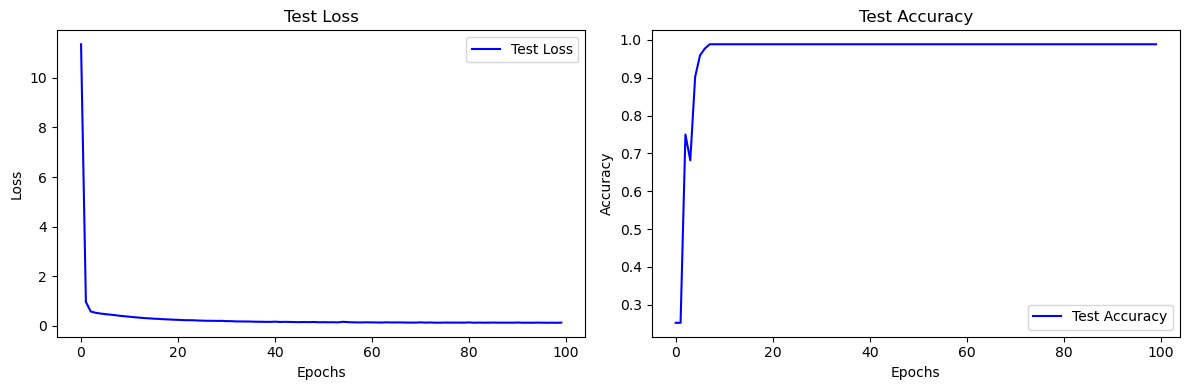

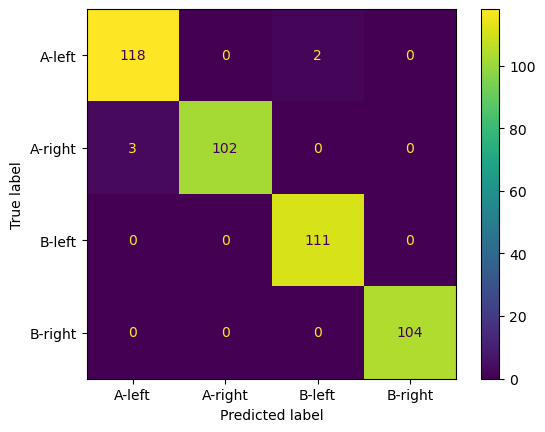

In [6]:
model3 = SimpleArchitectureWithPooling(filter_size=2, input_size=dset.input_size, max_pool_size=50)

model3.conv[0] = model1.conv[0]
model3.conv[1] = model1.conv[1]

model3.conv.apply(lambda m: set_requires_grad(m, False))

phase3 = Experiment2(trainloader=trainloader, testloader=testloader, label_map=dset.label_map, model=model3, lr=1e-2, epochs=100)

phase3.run()

In [7]:
output_embeddings_m3 = model3.get_output_embeddings(testloader)

(len(output_embeddings_m3), len(output_embeddings_m3[0]))

(440, 4)

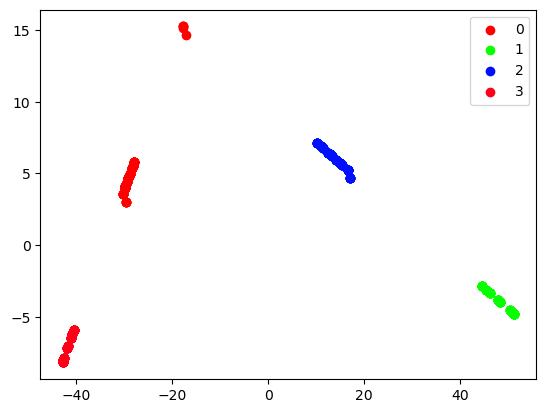

In [8]:
plot_clusters(output_embeddings_m3, 4)

# Phase 4

100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


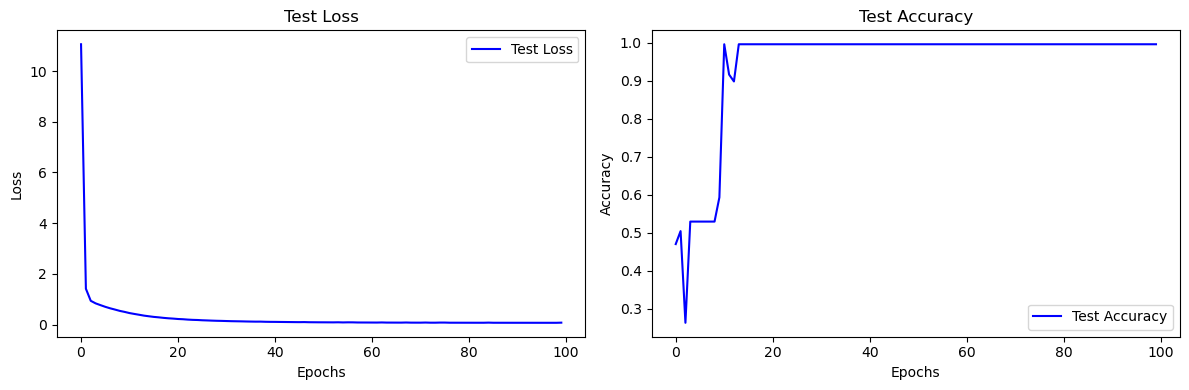

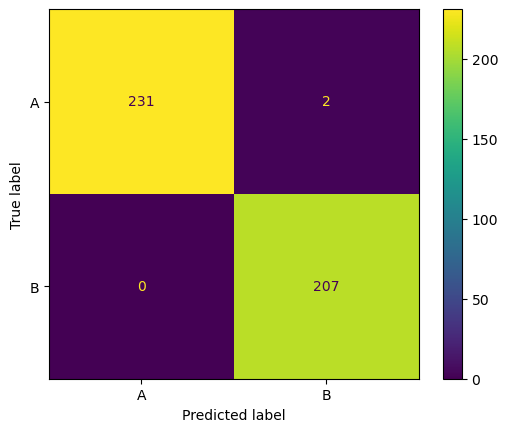

In [9]:
model4 = SimpleArchitectureWithPooling(filter_size=2, input_size=dset.input_size, max_pool_size=50, fc_output_size=2)

model4.conv[0] = model1.conv[0]
model4.conv[1] = model1.conv[1]

model4.conv.apply(lambda m: set_requires_grad(m, False))

phase4 = Experiment2(trainloader=btrainloader, testloader=btestloader, label_map=binary_dset.label_map, model=model4, lr=1e-2, epochs=100)

phase4.run()

In [10]:
output_embeddings_m4 = model4.get_output_embeddings(btestloader)

(len(output_embeddings_m4), len(output_embeddings_m4[0]))

(440, 2)

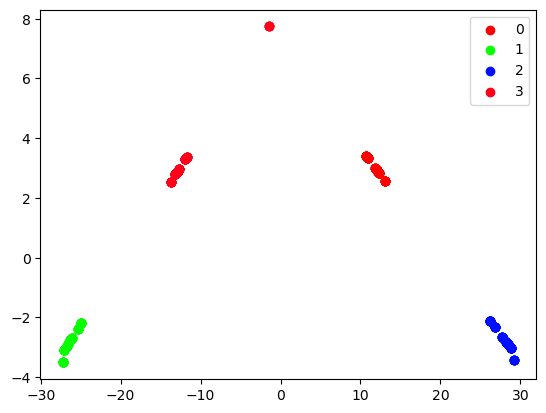

In [11]:
plot_clusters(output_embeddings_m4, 4)

# Phase 5

100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


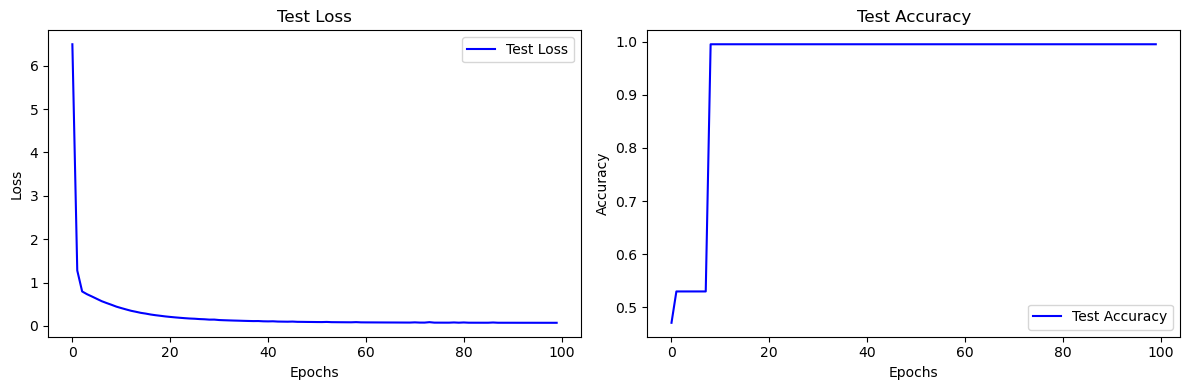

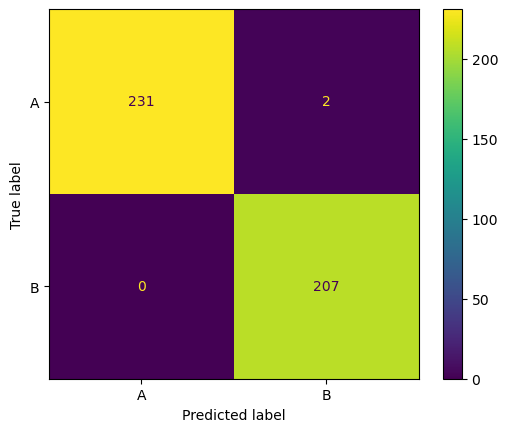

In [12]:
model5 = SimpleArchitectureWithPooling(filter_size=2, input_size=dset.input_size, max_pool_size=100, fc_output_size=2)

model5.conv[0] = model1.conv[0]
model5.conv[1] = model1.conv[1]

model5.conv.apply(lambda m: set_requires_grad(m, False))

phase5 = Experiment2(trainloader=btrainloader, testloader=btestloader, label_map=binary_dset.label_map, model=model5, lr=1e-2, epochs=100)

phase5.run()

In [13]:
output_embeddings_m5 = model5.get_output_embeddings(btestloader)

(len(output_embeddings_m5), len(output_embeddings_m5[0]))

(440, 2)

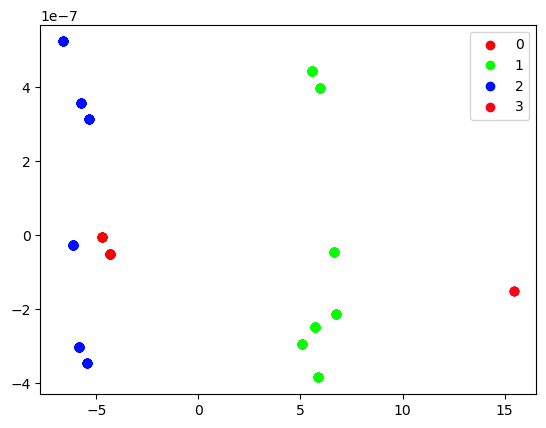

In [14]:
plot_clusters(output_embeddings_m5, 4)

# Phase 6

100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


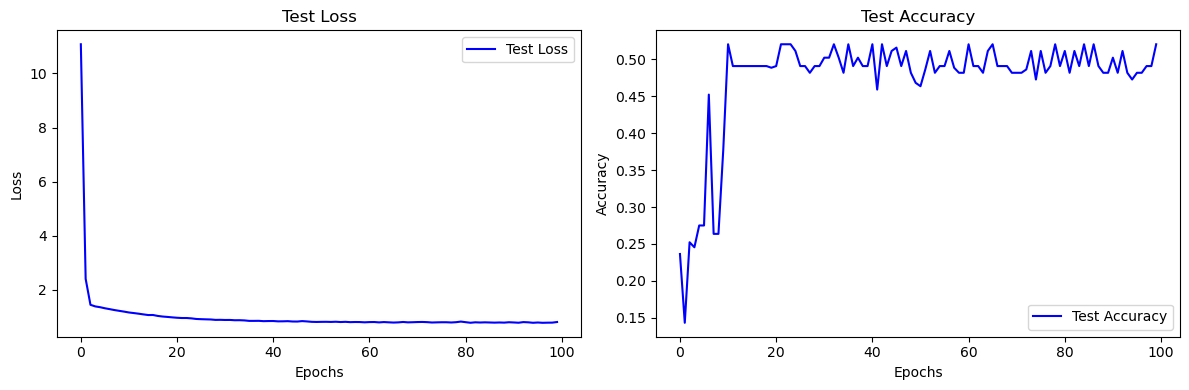

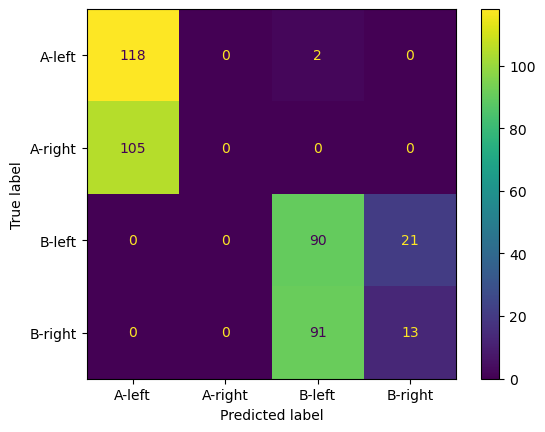

In [15]:
model6 = SimpleArchitectureWithPooling(filter_size=2, input_size=dset.input_size, max_pool_size=100, fc_output_size=4)

model6.conv[0] = model1.conv[0]
model6.conv[1] = model1.conv[1]

model6.conv.apply(lambda m: set_requires_grad(m, False))

phase6 = Experiment2(trainloader=trainloader, testloader=testloader, label_map=dset.label_map, model=model6, lr=1e-2, epochs=100)

phase6.run()

In [16]:
output_embeddings_m6 = model6.get_output_embeddings(btestloader)

(len(output_embeddings_m6), len(output_embeddings_m6[0]))

(440, 4)

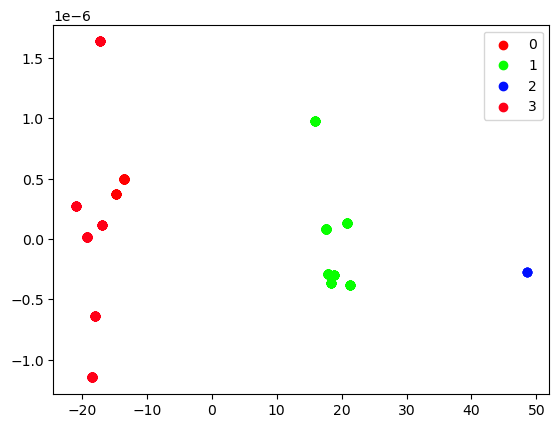

In [17]:
plot_clusters(output_embeddings_m6, 4)

# Intrinsic dimension estimation

In [18]:
sample_x = testset.dataset.tensors[0].flatten(start_dim=1)

sample_x = sample_x[:202, :]

id_estim = skdim.id.TwoNN().fit_transform(sample_x)

print(f'intrinsic dimension estimation: {id_estim}')

intrinsic dimension estimation: 0.5447217573106433
